In [1]:
import tensorflow as tf
from keras import optimizers
from keras.models import Sequential, Model
import warnings
warnings.filterwarnings("ignore")
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from keras.layers import RepeatVector, TimeDistributed
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout,LSTM,Dense,InputLayer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanSquaredLogarithmicError
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
test_file_url='https://drive.google.com/file/d/14oAY9wAxqaJcjmljQlx1d4qc2w3SAMIE/view?usp=share_link'
test_file_url.split('/')[-2]
test_ds='https://drive.google.com/uc?id='+(test_file_url.split('/')[-2])
test_data=pd.read_csv(test_ds,parse_dates=['date'])
test_data.head(5)

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [3]:
train_ds="/content/train.csv"
oil_ds="/content/oil.csv"
holiday_ds="/content/holidays_events.csv"
tran_ds="/content/transactions.csv"
store_ds="/content/stores.csv"
train_data=pd.read_csv(train_ds)
holiday_data=pd.read_csv(holiday_ds)
oil_data=pd.read_csv(oil_ds)
store_data=pd.read_csv(store_ds)
tran_data=pd.read_csv(tran_ds)
train_data.head(5)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
holiday_data.head(5)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [ ]:
oil_data.head(5)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [ ]:
store_data.head(5)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [ ]:
tran_data.head(5)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [5]:
data=train_data.merge(holiday_data,on="date",how="left")
data=data.merge(oil_data,on="date",how="left")
data=data.merge(store_data,on="store_nbr",how="left")
data=data.merge(tran_data,on=["date","store_nbr"],how="left")
data=data.rename(columns={"type_x":"holiday_type","type_y":"store_type"})

In [6]:
data["date"]=pd.to_datetime(data["date"])
data["day_of_week"]=data["date"].dt.day_name()
data["month"]=data["date"].dt.month
data["quarter"]=data["date"].dt.quarter
data["year"]=data["date"].dt.year
data["week"]=data["date"].dt.isocalendar().week

In [7]:
data.head(5)

,id,date,store_nbr,family,sales,onpromotion,holiday_type,locale,locale_name,description,...,city,state,store_type,cluster,transactions,day_of_week,month,quarter,year,week
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,...,Quito,Pichincha,D,13,NaN,Tuesday,1,1,2013,1
1,1,2013-01-01,1,BABY CARE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,...,Quito,Pichincha,D,13,NaN,Tuesday,1,1,2013,1
2,2,2013-01-01,1,BEAUTY,0.0,0,Holiday,National,Ecuador,Primer dia del ano,...,Quito,Pichincha,D,13,NaN,Tuesday,1,1,2013,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,Holiday,National,Ecuador,Primer dia del ano,...,Quito,Pichincha,D,13,NaN,Tuesday,1,1,2013,1
4,4,2013-01-01,1,BOOKS,0.0,0,Holiday,National,Ecuador,Primer dia del ano,...,Quito,Pichincha,D,13,NaN,Tuesday,1,1,2013,1


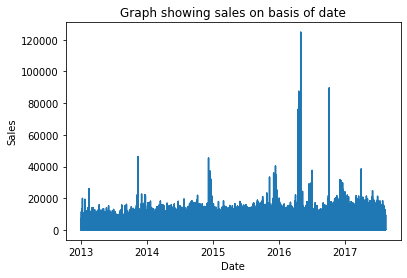

In [8]:
plt.plot(data["date"],data["sales"])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Graph showing sales on basis of date")
plt.show()

In [9]:
data_b=data[data["family"]=="BOOKS" ]

In [10]:
data_b["holiday_type"]=data_b["holiday_type"].replace({"Transfer":"Normal"})
data_b["holiday_type"]=data_b["holiday_type"].replace({np.nan:"Normal"})

In [11]:
cols=["sales","date","onpromotion","holiday_type","dcoilwtico","transactions","day_of_week"]
data=data_b.loc[:,cols]

In [12]:
data=data[data["transactions"].isnull()==False]

In [13]:
data["dcoilwtico"]=data["dcoilwtico"].fillna(method='ffill')
data["dcoilwtico"]=data["dcoilwtico"].fillna(method='bfill')

In [14]:
data_final=pd.get_dummies(data,prefix=["holiday_type","day_of_week"])
data_final.head(5)

,sales,date,onpromotion,dcoilwtico,transactions,holiday_type_Additional,holiday_type_Bridge,holiday_type_Event,holiday_type_Holiday,holiday_type_Normal,holiday_type_Work Day,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
565,0.0,2013-01-01,0,93.14,770.0,0,0,0,1,0,0,0,0,0,0,0,1,0
1786,0.0,2013-01-02,0,93.14,2111.0,0,0,0,0,1,0,0,0,0,0,0,0,1
1819,0.0,2013-01-02,0,93.14,1293.0,0,0,0,0,1,0,0,0,0,0,0,0,1
1852,0.0,2013-01-02,0,93.14,3547.0,0,0,0,0,1,0,0,0,0,0,0,0,1
1885,0.0,2013-01-02,0,93.14,1362.0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [15]:
grp=data_final.groupby("date").agg(np.mean)
grp.head(5)

,sales,onpromotion,dcoilwtico,transactions,holiday_type_Additional,holiday_type_Bridge,holiday_type_Event,holiday_type_Holiday,holiday_type_Normal,holiday_type_Work Day,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
date,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,93.14,770.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2013-01-02,0.0,0.0,93.14,2026.413043,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2013-01-03,0.0,0.0,92.97,1706.608696,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2013-01-04,0.0,0.0,93.12,1706.391304,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-05,0.0,0.0,93.12,2034.195652,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [16]:
def convert_supervised(enc,wd=1):
    enc=enc.to_numpy()
    data=list()
    label=list()
    for i in range(len(enc)-wd):
      for k in enc[i:i+wd]:
        r=[[k]]
      data.append(r)
      m=enc[i+wd]
      label.append(m)
    data=np.array(data)
    label=np.array(label)
    return data,label

In [17]:
series_data=grp["sales"]
X,y=convert_supervised(series_data,30)
print(X.shape)
print(y.shape)

(1652, 1, 1)
(1652,)


In [18]:
X_Train,X_Test,Y_Train,Y_Test=train_test_split(X,y,test_size=0.2,random_state=0)#splitting into training and testing
X_Train,X_Val,Y_Train,Y_Val=train_test_split(X_Train,Y_Train,test_size=0.15,random_state=0)#Splitting further into Training and validation

In [19]:
model=Sequential([
    InputLayer((1, 1)),
    LSTM(128,activation="relu"),
    Dense(64,activation="relu"),
    Dense(8,activation="relu"),
    Dense(1,activation="sigmoid")
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 75,345
Trainable params: 75,345
Non-trainable params: 0
_________________________________________________________________


In [20]:
from keras import backend as K
def root_mean_squared_logarithmic_error(y_true, y_pred):
  return K.sqrt(K.mean(K.square((K.log(y_true+1)-K.log(y_pred+1)))))

In [21]:
model.compile(loss="mae",optimizer=Adam(learning_rate=0.001),metrics=[root_mean_squared_logarithmic_error])

In [22]:
history=model.fit(X_Train,Y_Train,validation_data=(X_Val,Y_Val),epochs=500,batch_size=100)

Epoch 1/500
12/12 [==============================] - 3s 36ms/step - loss: 0.4710 - root_mean_squared_logarithmic_error: 0.3848 - val_loss: 0.4727 - val_root_mean_squared_logarithmic_error: 0.3843
Epoch 2/500
12/12 [==============================] - 0s 10ms/step - loss: 0.4603 - root_mean_squared_logarithmic_error: 0.3777 - val_loss: 0.4609 - val_root_mean_squared_logarithmic_error: 0.3760
Epoch 3/500
12/12 [==============================] - 0s 10ms/step - loss: 0.4460 - root_mean_squared_logarithmic_error: 0.3666 - val_loss: 0.4447 - val_root_mean_squared_logarithmic_error: 0.3647
Epoch 4/500
12/12 [==============================] - 0s 10ms/step - loss: 0.4262 - root_mean_squared_logarithmic_error: 0.3528 - val_loss: 0.4221 - val_root_mean_squared_logarithmic_error: 0.3488
Epoch 5/500
12/12 [==============================] - 0s 9ms/step - loss: 0.3989 - root_mean_squared_logarithmic_error: 0.3347 - val_loss: 0.3910 - val_root_mean_squared_logarithmic_error: 0.3264
Epoch 6/500
12/12 [==

In [23]:
model.evaluate(X_Test,Y_Test)

11/11 [==============================] - 0s 2ms/step - loss: 0.0217 - root_mean_squared_logarithmic_error: 0.0487


[0.021674485877156258, 0.04874149709939957]

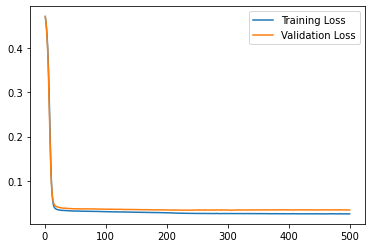

In [24]:
plt.plot((range(1,len(history.history["loss"])+1)),history.history["loss"],label="Training Loss")
plt.plot((range(1,len(history.history["val_loss"])+1)),history.history["val_loss"],label="Validation Loss")
plt.legend()
plt.show()

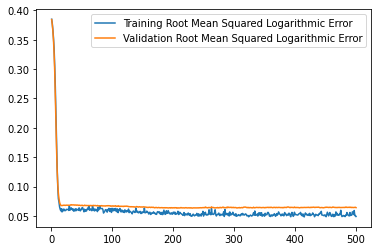

In [25]:
plt.plot((range(1,len(history.history["root_mean_squared_logarithmic_error"])+1)),history.history["root_mean_squared_logarithmic_error"],label="Training Root Mean Squared Logarithmic Error")
plt.plot((range(1,len(history.history["val_root_mean_squared_logarithmic_error"])+1)),history.history["val_root_mean_squared_logarithmic_error"],label="Validation Root Mean Squared Logarithmic Error")
plt.legend()
plt.show()